# Credit

#### I used the below Repository by thisisiron to learn about training a model using gradient tape
##### Thank you thisisiron! 

https://github.com/thisisiron/TF2-GAN

# Imports

In [200]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import os
import time
import tensorflow_datasets as tfds
warnings.filterwarnings("ignore")

 ## Import Data

In [201]:
data, info = tfds.load("mnist", with_info=True)

In [202]:
train_data = data['train']
ds = train_data.take(5)

['image', 'label']


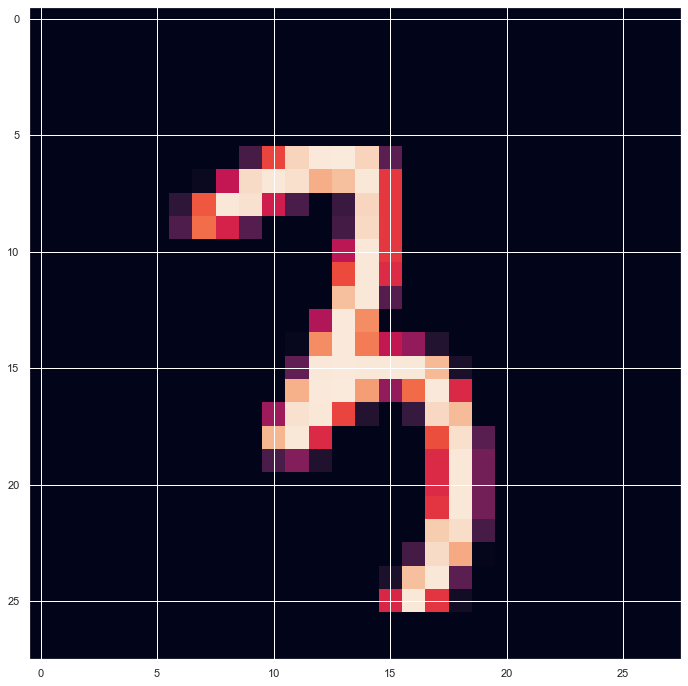

(28, 28, 1)


In [203]:
for example in train_data:
    print(list(example.keys()))
    image = example["image"]
    label = example["label"]
    plt.imshow(image)
    plt.show()
    print(image.shape)
    break

# Training using Gradient Tape

## Loss Function

In [204]:
# loss object: Binary Crossentropy Loss
# real_output: Image from Data
# fae_output: Image from Generator
def discriminator_loss(loss_object, real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# loss object: Binary Crossentropy Loss
# discriminator_probability: Result from Discriminator 0 = Fake 1 = Real
def generator_loss(loss_object, discriminator_probability):
    return loss_object(tf.ones_like(discriminator_probability), discriminator_probability)

# Normalize Image between [-1,1]
def normalize(x):
    image = tf.cast(x['image'], tf.float32)
    image = (image / 127.5) - 1
    return image

# Save Image sample from Generator
def save_imgs(epoch, generator, noise):
    gen_imgs = generator(noise)

    fig = plt.figure(figsize=(4, 4))

    for i in range(gen_imgs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    fig.savefig("images/mnist_%d.png" % epoch)

## Train Function

In [205]:
def train(train_dataset, generator, discriminator):
    # Setting Dimension of Input Noise
    latent_dim = 10
    epochs = 1000
    batch_size = 2000
    # Random Seed for Shuffling Data
    buffer_size = 6000
    # Model Saved after
    save_interval = 50

    # defining optimizer for Models
    gen_optimizer = tf.keras.optimizers.Adam(0.0001)
    disc_optimizer = tf.keras.optimizers.Adam(0.0001)
    
    # Shuffle & Batch Data
    train_dataset = train_data.map(normalize).shuffle(buffer_size , reshuffle_each_iteration=True).batch(batch_size)
    
    # Define Loss Function
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Directory to store generated images
    if not os.path.exists('./images'):
        os.makedirs('./images')

    # @tf.function: The below function is completely Tensor Code
    # Good for optimization
    @tf.function
    def train_step(image):
        noise = tf.random.normal([batch_size, latent_dim])

        # Define the loss function
        with tf.GradientTape(persistent=True) as tape:
            generated_images = generator(noise)

            real_output = discriminator(images)
            generated_output = discriminator(generated_images)

            gen_loss = generator_loss(cross_entropy, generated_output)
            disc_loss = discriminator_loss(cross_entropy, real_output, generated_output)

        # Calculate Gradient
        grad_disc = tape.gradient(disc_loss, discriminator.trainable_variables)
        grad_gen = tape.gradient(gen_loss, generator.trainable_variables)

        # Optimization Step: Update Weights & Learning Rate
        disc_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))
        gen_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))

        return gen_loss, disc_loss

    # Seed to Generate Fake Images
    seed = tf.random.normal([16, latent_dim])

    for epoch in range(epochs):
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        for images in train_dataset:
            gen_loss, disc_loss = train_step(images)

            total_gen_loss += gen_loss
            total_disc_loss += disc_loss

        print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time() - start, total_gen_loss / batch_size, total_disc_loss / batch_size))
        if epoch % save_interval == 0:
            save_imgs(epoch, generator, seed)
        

## Build Model

In [206]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.dense_1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.dense_2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense_3 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.dense_4 = tf.keras.layers.Dense(28 * 28)
        self.reshape = tf.keras.layers.Reshape((28, 28, 1))

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        return self.reshape(x)


class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu )
        self.dense_2 = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu )
        self.dense_3 = tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu)
        self.dense_4 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        return self.dense_4(x)

### Initiate Models

In [70]:
disc = Discriminator()
gen = Generator()

### Train

Gen Loss () Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Diisc Loss () Tensor("add:0", shape=(), dtype=float32)
Gen Loss () Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Diisc Loss () Tensor("add:0", shape=(), dtype=float32)
Time for epoch 1 is 1.8884928226470947 sec - gen_loss = 0.008704346604645252, disc_loss = 0.01281167846173048
Time for epoch 2 is 1.0412342548370361 sec - gen_loss = 0.015599680133163929, disc_loss = 0.007164367474615574
Time for epoch 3 is 1.0647437572479248 sec - gen_loss = 0.01874624565243721, disc_loss = 0.005488631781190634
Time for epoch 4 is 1.0632381439208984 sec - gen_loss = 0.024533236399292946, disc_loss = 0.003647436387836933
Time for epoch 5 is 1.0908210277557373 sec - gen_loss = 0.030450334772467613, disc_loss = 0.0023632061202079058
Time for epoch 6 is 1.0851118564605713 sec - gen_loss = 0.0298005361109972, disc_loss = 0.0024830137845128775
Time for epoch 7 is 1.1102492809295654 sec - gen

Time for epoch 72 is 1.1891562938690186 sec - gen_loss = 0.053288571536540985, disc_loss = 0.000787553668487817
Time for epoch 73 is 1.1007611751556396 sec - gen_loss = 0.05522846058011055, disc_loss = 0.0006844353047199547
Time for epoch 74 is 1.1742644309997559 sec - gen_loss = 0.051495712250471115, disc_loss = 0.0008612356032244861
Time for epoch 75 is 1.2038624286651611 sec - gen_loss = 0.05048269033432007, disc_loss = 0.0009889478096738458
Time for epoch 76 is 1.1328136920928955 sec - gen_loss = 0.05258174613118172, disc_loss = 0.0009307427681051195
Time for epoch 77 is 1.2657897472381592 sec - gen_loss = 0.054037079215049744, disc_loss = 0.0010270773200318217
Time for epoch 78 is 1.2102715969085693 sec - gen_loss = 0.05379677936434746, disc_loss = 0.0010726585751399398
Time for epoch 79 is 1.1837842464447021 sec - gen_loss = 0.05615191534161568, disc_loss = 0.0009251238079741597
Time for epoch 80 is 1.1862668991088867 sec - gen_loss = 0.05923375114798546, disc_loss = 0.0007775590

Time for epoch 146 is 1.2072725296020508 sec - gen_loss = 0.08169512450695038, disc_loss = 0.0008784217061474919
Time for epoch 147 is 1.2628145217895508 sec - gen_loss = 0.16429713368415833, disc_loss = 0.0014855485642328858
Time for epoch 148 is 1.348304033279419 sec - gen_loss = 0.13499513268470764, disc_loss = 0.0006140314508229494
Time for epoch 149 is 1.2232749462127686 sec - gen_loss = 0.07496973127126694, disc_loss = 0.0006289375596679747
Time for epoch 150 is 1.1822657585144043 sec - gen_loss = 0.07342764735221863, disc_loss = 0.0006252131424844265
Time for epoch 151 is 1.1658506393432617 sec - gen_loss = 0.0757756307721138, disc_loss = 0.0004885525559075177
Time for epoch 152 is 1.2282779216766357 sec - gen_loss = 0.07908228039741516, disc_loss = 0.00030159950256347656
Time for epoch 153 is 1.237278699874878 sec - gen_loss = 0.0771009624004364, disc_loss = 0.00027102173771709204
Time for epoch 154 is 1.2212743759155273 sec - gen_loss = 0.08001121878623962, disc_loss = 0.00045

Time for epoch 219 is 1.2914316654205322 sec - gen_loss = 0.0740155577659607, disc_loss = 0.0008607824565842748
Time for epoch 220 is 1.2472805976867676 sec - gen_loss = 0.07463719695806503, disc_loss = 0.0004993634065613151
Time for epoch 221 is 1.1982693672180176 sec - gen_loss = 0.0737072303891182, disc_loss = 0.0006784404977224767
Time for epoch 222 is 1.2792882919311523 sec - gen_loss = 0.07954291254281998, disc_loss = 0.0008768429979681969
Time for epoch 223 is 1.2958266735076904 sec - gen_loss = 0.08690105378627777, disc_loss = 0.0009088428923860192
Time for epoch 224 is 1.2362782955169678 sec - gen_loss = 0.12228016555309296, disc_loss = 0.002371108392253518
Time for epoch 225 is 1.2302765846252441 sec - gen_loss = 0.5405368208885193, disc_loss = 0.017044786363840103
Time for epoch 226 is 1.2772867679595947 sec - gen_loss = 0.11578106135129929, disc_loss = 0.004816161934286356
Time for epoch 227 is 1.2752866744995117 sec - gen_loss = 0.07743654400110245, disc_loss = 0.002855361

Time for epoch 292 is 1.3012924194335938 sec - gen_loss = 0.07349605113267899, disc_loss = 0.00037321573472581804
Time for epoch 293 is 1.2422807216644287 sec - gen_loss = 0.07652734965085983, disc_loss = 0.00036504893796518445
Time for epoch 294 is 1.2537879943847656 sec - gen_loss = 0.0824279636144638, disc_loss = 0.00040865110349841416
Time for epoch 295 is 1.250281572341919 sec - gen_loss = 0.0787556916475296, disc_loss = 0.00039721126086078584
Time for epoch 296 is 1.3202972412109375 sec - gen_loss = 0.07846800982952118, disc_loss = 0.0003280972596257925
Time for epoch 297 is 1.4153180122375488 sec - gen_loss = 0.08132775872945786, disc_loss = 0.0002659108431544155
Time for epoch 298 is 1.2564215660095215 sec - gen_loss = 0.07848221808671951, disc_loss = 0.00035664343158714473
Time for epoch 299 is 1.1987781524658203 sec - gen_loss = 0.08315624296665192, disc_loss = 0.00039192289113998413
Time for epoch 300 is 1.292301893234253 sec - gen_loss = 0.09534188359975815, disc_loss = 0.0

Time for epoch 365 is 1.2479827404022217 sec - gen_loss = 0.07486730813980103, disc_loss = 0.0004252608632668853
Time for epoch 366 is 1.1802656650543213 sec - gen_loss = 0.07679304480552673, disc_loss = 0.00036938433186151087
Time for epoch 367 is 1.296705722808838 sec - gen_loss = 0.08055603504180908, disc_loss = 0.0003622187068685889
Time for epoch 368 is 1.2572824954986572 sec - gen_loss = 0.0851023942232132, disc_loss = 0.0004288244235794991
Time for epoch 369 is 1.1963181495666504 sec - gen_loss = 0.08621476590633392, disc_loss = 0.00046785554150119424
Time for epoch 370 is 1.2972924709320068 sec - gen_loss = 0.08522788435220718, disc_loss = 0.0004722589219454676
Time for epoch 371 is 1.3173129558563232 sec - gen_loss = 0.08924219012260437, disc_loss = 0.0005408240249380469
Time for epoch 372 is 1.263395071029663 sec - gen_loss = 0.09470376372337341, disc_loss = 0.000583031855057925
Time for epoch 373 is 1.2627911567687988 sec - gen_loss = 0.09949853271245956, disc_loss = 0.00069

Time for epoch 438 is 1.269298791885376 sec - gen_loss = 0.07795976847410202, disc_loss = 0.0010507594561204314
Time for epoch 439 is 1.2615885734558105 sec - gen_loss = 0.07383256405591965, disc_loss = 0.0008794196764938533
Time for epoch 440 is 1.2872889041900635 sec - gen_loss = 0.07416039705276489, disc_loss = 0.0008361365762539208
Time for epoch 441 is 1.416318416595459 sec - gen_loss = 0.07938916981220245, disc_loss = 0.0008212123648263514
Time for epoch 442 is 1.2537899017333984 sec - gen_loss = 0.07274819910526276, disc_loss = 0.0010847904486581683
Time for epoch 443 is 1.30533766746521 sec - gen_loss = 0.07519027590751648, disc_loss = 0.0009864423191174865
Time for epoch 444 is 1.2793185710906982 sec - gen_loss = 0.07565835118293762, disc_loss = 0.0008731645066291094
Time for epoch 445 is 1.2525107860565186 sec - gen_loss = 0.08014290034770966, disc_loss = 0.0005961647839285433
Time for epoch 446 is 1.3760101795196533 sec - gen_loss = 0.0757572203874588, disc_loss = 0.00076330

Time for epoch 511 is 1.1987860202789307 sec - gen_loss = 0.08914287388324738, disc_loss = 0.0017543027643114328
Time for epoch 512 is 1.2322771549224854 sec - gen_loss = 0.10735409706830978, disc_loss = 0.001834364142268896
Time for epoch 513 is 1.3272979259490967 sec - gen_loss = 0.10859111696481705, disc_loss = 0.0012965446803718805
Time for epoch 514 is 1.2223634719848633 sec - gen_loss = 0.09143384546041489, disc_loss = 0.0013500273926183581
Time for epoch 515 is 1.289290189743042 sec - gen_loss = 0.08927151560783386, disc_loss = 0.001227355096489191
Time for epoch 516 is 1.3067584037780762 sec - gen_loss = 0.07399507611989975, disc_loss = 0.0013124678516760468
Time for epoch 517 is 1.1792654991149902 sec - gen_loss = 0.0724874958395958, disc_loss = 0.0011059261159971356
Time for epoch 518 is 1.3543047904968262 sec - gen_loss = 0.07708106189966202, disc_loss = 0.0008359942003153265
Time for epoch 519 is 1.2842628955841064 sec - gen_loss = 0.07175401598215103, disc_loss = 0.0008254

Time for epoch 584 is 1.260385513305664 sec - gen_loss = 0.08023545891046524, disc_loss = 0.0007333692046813667
Time for epoch 585 is 1.2689845561981201 sec - gen_loss = 0.08504071086645126, disc_loss = 0.000569346419069916
Time for epoch 586 is 1.3058218955993652 sec - gen_loss = 0.09382197260856628, disc_loss = 0.0006182588404044509
Time for epoch 587 is 1.2462804317474365 sec - gen_loss = 0.09347689896821976, disc_loss = 0.0006666913395747542
Time for epoch 588 is 1.2783067226409912 sec - gen_loss = 0.09263136237859726, disc_loss = 0.0006909217336215079
Time for epoch 589 is 1.258298397064209 sec - gen_loss = 0.09738966077566147, disc_loss = 0.0006903606117703021
Time for epoch 590 is 1.2288615703582764 sec - gen_loss = 0.09732158482074738, disc_loss = 0.0006101247272454202
Time for epoch 591 is 1.237278938293457 sec - gen_loss = 0.09363691508769989, disc_loss = 0.000612922478467226
Time for epoch 592 is 1.2743358612060547 sec - gen_loss = 0.10166212171316147, disc_loss = 0.00093576

Time for epoch 657 is 1.3095316886901855 sec - gen_loss = 0.10117998719215393, disc_loss = 0.0013595211785286665
Time for epoch 658 is 1.2167086601257324 sec - gen_loss = 0.08639593422412872, disc_loss = 0.0012853416847065091
Time for epoch 659 is 1.2958123683929443 sec - gen_loss = 0.16200554370880127, disc_loss = 0.0028517155442386866
Time for epoch 660 is 1.2915263175964355 sec - gen_loss = 0.10812260955572128, disc_loss = 0.0023789487313479185
Time for epoch 661 is 1.264284372329712 sec - gen_loss = 0.09122569859027863, disc_loss = 0.0015152761479839683
Time for epoch 662 is 1.275364637374878 sec - gen_loss = 0.0848422423005104, disc_loss = 0.0013750542420893908
Time for epoch 663 is 1.2887940406799316 sec - gen_loss = 0.08884194493293762, disc_loss = 0.0014713096898049116
Time for epoch 664 is 1.3018171787261963 sec - gen_loss = 0.0912807360291481, disc_loss = 0.001307974336668849
Time for epoch 665 is 1.1992700099945068 sec - gen_loss = 0.09827965497970581, disc_loss = 0.00104848

Time for epoch 730 is 1.2732863426208496 sec - gen_loss = 0.11432746052742004, disc_loss = 0.0009877721313387156
Time for epoch 731 is 1.2522826194763184 sec - gen_loss = 0.1058613732457161, disc_loss = 0.0010462573263794184
Time for epoch 732 is 1.2792878150939941 sec - gen_loss = 0.09953957796096802, disc_loss = 0.0010110745206475258
Time for epoch 733 is 1.2448618412017822 sec - gen_loss = 0.10113464295864105, disc_loss = 0.0009696049382910132
Time for epoch 734 is 1.2712860107421875 sec - gen_loss = 0.10345496237277985, disc_loss = 0.0009468960925005376
Time for epoch 735 is 1.281458854675293 sec - gen_loss = 0.09963652491569519, disc_loss = 0.0010179628152400255
Time for epoch 736 is 1.2772879600524902 sec - gen_loss = 0.10262437164783478, disc_loss = 0.0009966534562408924
Time for epoch 737 is 1.2727916240692139 sec - gen_loss = 0.10033191740512848, disc_loss = 0.0011057864176109433
Time for epoch 738 is 1.2412796020507812 sec - gen_loss = 0.10036266595125198, disc_loss = 0.00104

Time for epoch 803 is 1.2962920665740967 sec - gen_loss = 0.11973001807928085, disc_loss = 0.0003608818515203893
Time for epoch 804 is 1.3027989864349365 sec - gen_loss = 0.11818169802427292, disc_loss = 0.00043557106982916594
Time for epoch 805 is 1.2968475818634033 sec - gen_loss = 0.11133342981338501, disc_loss = 0.0005032892804592848
Time for epoch 806 is 1.2582981586456299 sec - gen_loss = 0.09998742491006851, disc_loss = 0.0005429633893072605
Time for epoch 807 is 1.2742869853973389 sec - gen_loss = 0.1011451706290245, disc_loss = 0.0004439690674189478
Time for epoch 808 is 1.2968761920928955 sec - gen_loss = 0.11479727923870087, disc_loss = 0.0005919265677221119
Time for epoch 809 is 1.3085651397705078 sec - gen_loss = 0.13801775872707367, disc_loss = 0.0007687656907364726
Time for epoch 810 is 1.2732875347137451 sec - gen_loss = 0.12230765074491501, disc_loss = 0.0006941449828445911
Time for epoch 811 is 1.2458548545837402 sec - gen_loss = 0.16909000277519226, disc_loss = 0.002

Time for epoch 876 is 1.2714169025421143 sec - gen_loss = 0.2882098853588104, disc_loss = 0.0037695900537073612
Time for epoch 877 is 1.249281883239746 sec - gen_loss = 0.1730736941099167, disc_loss = 0.0014712647534906864
Time for epoch 878 is 1.3186261653900146 sec - gen_loss = 0.10056209564208984, disc_loss = 0.0008750759297981858
Time for epoch 879 is 1.2602930068969727 sec - gen_loss = 0.09651167690753937, disc_loss = 0.0008147422922775149
Time for epoch 880 is 1.251281499862671 sec - gen_loss = 0.09873655438423157, disc_loss = 0.0006278143846429884
Time for epoch 881 is 1.3052940368652344 sec - gen_loss = 0.09954889863729477, disc_loss = 0.000655939569696784
Time for epoch 882 is 1.257789134979248 sec - gen_loss = 0.09565143287181854, disc_loss = 0.0007145196432247758
Time for epoch 883 is 1.3593060970306396 sec - gen_loss = 0.10021582990884781, disc_loss = 0.0007254672236740589
Time for epoch 884 is 1.2953004837036133 sec - gen_loss = 0.10305910557508469, disc_loss = 0.000652503

Time for epoch 949 is 1.2723186016082764 sec - gen_loss = 0.1721504032611847, disc_loss = 0.00045592637616209686
Time for epoch 950 is 1.3102943897247314 sec - gen_loss = 0.18389904499053955, disc_loss = 0.0006440395372919738
Time for epoch 951 is 1.2572858333587646 sec - gen_loss = 0.16332964599132538, disc_loss = 0.0004542520036920905
Time for epoch 952 is 1.264876127243042 sec - gen_loss = 0.2642356753349304, disc_loss = 0.0008786733378656209
Time for epoch 953 is 1.2495934963226318 sec - gen_loss = 0.1624971181154251, disc_loss = 0.0004657582612708211
Time for epoch 954 is 1.2672863006591797 sec - gen_loss = 0.1676464080810547, disc_loss = 0.0004717055126093328
Time for epoch 955 is 1.265777349472046 sec - gen_loss = 0.15191727876663208, disc_loss = 0.0004771262756548822
Time for epoch 956 is 1.300623893737793 sec - gen_loss = 0.14508992433547974, disc_loss = 0.00044210493797436357
Time for epoch 957 is 1.2067902088165283 sec - gen_loss = 0.1269511580467224, disc_loss = 0.000471797

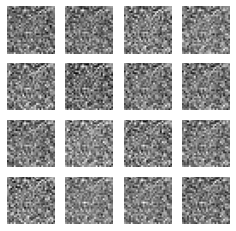

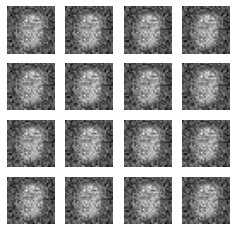

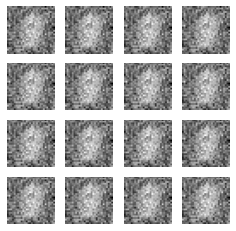

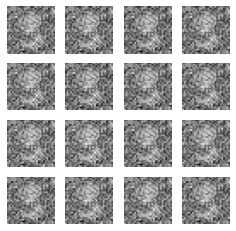

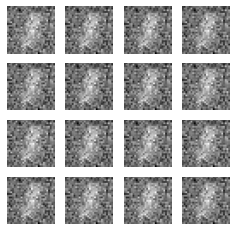

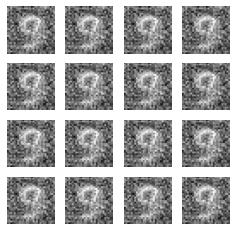

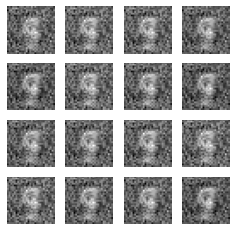

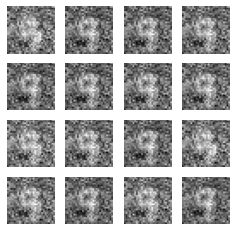

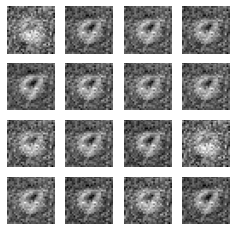

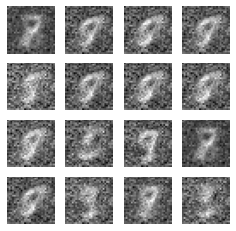

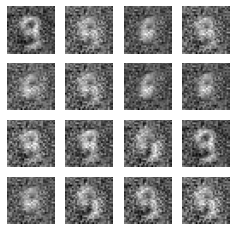

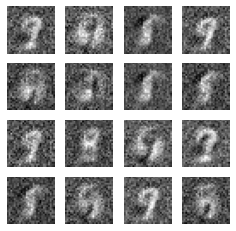

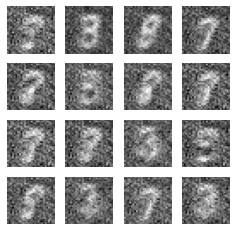

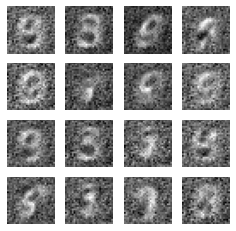

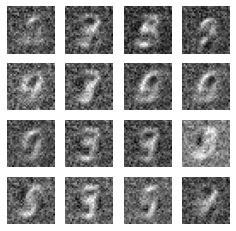

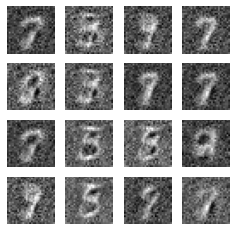

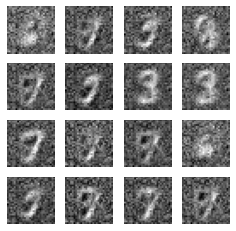

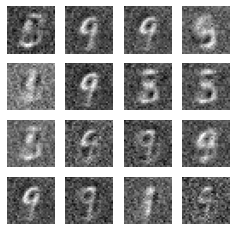

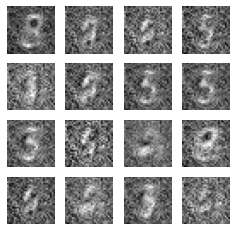

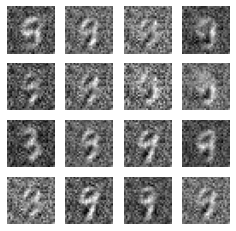

In [71]:
train(train_data, gen, disc)

### Save Weights

In [89]:
disc.save_weights('./models/discriminator')
gen.save_weights('./models/generator')

### Load Models

In [215]:
from tensorflow.keras.models import load_model
disc1 = Discriminator()
gen1 = Generator()
disc1.load_weights('./models/discriminator')
gen1.load_weights('./models/generator')